# Topic Modelling Overview

*This notebook provides an overview of various techniques commonly used in [topic modelling](https://en.wikipedia.org/wiki/Vector_space_model).* We will be using the [`sklearn`](https://en.wikipedia.org/wiki/Vector_space_model) library to demonstrate the techniques and models discussed, though they are also present in other libraries like [`gensim`](https://en.wikipedia.org/wiki/Vector_space_model).

> **Author's note**: The information presented here my interpretations of the various sources on the topic of topic modelling and hence some information may be inaccurate.

**Run the code cell below before you proceed!**

In [7]:
from nlp import *
import pandas as pd

# Enable interactive 3D graph
%matplotlib widget


example_corpus = ["dog bites man", "man bites dog", 
                  "dog bites meat and dog eats meat"]

news_df = pd.read_csv("./dataset/abcnews-date-text.csv", nrows=10000)
preprocess_df(news_df, "headline_text", inplace=True)
news_corpus = news_df['headline_text_preprocessed']


def print_matrix(pretext, matrix):
    print(pretext)
    for i in range(matrix.shape[0]):
        print(f'Document {i}:\t[', end='')
        for j in range(matrix.shape[1]):
            print(f'{matrix[i, j]:.3f}', end='')
            if j + 1 != matrix.shape[1]:
                print(f',\t', end='')
        print(']')

---

## Overview
- [Introduction - What is Topic Modelling?](#introduction)
    - [Key Definitions](#definitions)
    - [What is a "Topic"?](#topic)
- [Vectorisation](#vectorisation)
    - [Vector Space Model](#vector-space)
    - [Document-Term Matrix](#document-term)
    - [Vectorisation Techniques](#vectorisation-techniques)
        - [Bag-of-Word (BoW)](#bow)
        - [Bag-of-$n$-Grams](#bog)
        - [TF-IDF](#tfidf)
- [Topic Models](#models)
    - [Latent Dirichlet Allocation (LDA)](#lda)
        - [Blackbox Overview](#lda-overview)
            - [Document Generation Process (plain-English)](#lda-doc-gen-eng)
        - [Formalised Details](#lda-formalised-details)
            - [Variable Names Definition](#ida-formalised-variables)
            - [Formalised Document Generation Process](#lda-doc-gen-formalised)
            - [Dirichlet Distribution](#dirichlet-dist)
            - [Topic Inference](#ida-topic-inference)

---

<a id="introduction"></a>
## 1. Introduction - What is Topic Modelling?
> **Topic modelling** is a subfield of **Natural Language Processing** (NLP) concerned with finding abstract *topics* in a collection of documents.

<a id="definitions"></a>
### Key Definitions

| Key term   | Definition                                                                                                |
| ---------- | --------------------------------------------------------------------------------------------------------- |
| Document   | A single text; e.g. a sentence, tweet, essay, or a Wikipedia article.                                     |
| Corpus     | A collection of documents.                                                                                |
| Term       | Individual words or phrases in the vocabulary.                                                            |
| Vocabulary | A set of all relevant terms throughout the entire corpus (excludes stop words and other irrelevant terms) |



<a id="topic"></a>
### What is a "Topic"?
A **topic** is a set of words, that together suggest a shared theme. For example, consider the following set:
$$
\set{\text{human, nucleus, DNA, codon, adenine, cell}}
$$
We can infer that the topic may be "genetics", or "human biology" etc. - **note that we must interpret and assign the actual topic manually by looking at the words**. Often we may need to look into the documents themselves to gain a better insight on what the actual topic is.

A topic can also be described as a *probability distribution* over the vocabulary. Say that we have some documents about "photosynthesis" and some documents about the "effect of chocolate on pets" in our corpus. We've removed all stop words like "the" but forgot to remove the word "and".
$$
 \text{vocab} = \set{\text{dog, chloroplast, photosynthesis, cat, leaf, glucose, chocolate, and}}
$$
Intuitively we know that a document about "photosynthesis" will have more occurrence of terms like "leaf" or "chloroplast" - hence we may have a probability distribution like this for that topic:

![](attachments/1.png)


We can then define topic as the set of terms from the vocabulary with high probability of occuring. In that case, the topic "photosynthesis" will be the set:
$$
 \text{photosynthesis}_\text{topic} = \set{\text{chloroplast, photosynthesis, leaf, glucose}}
$$

Topic modelling is thus about finding these hidden sets of words with shared theme within a given corpus.

---

<a id="vectorisation"></a>
## 2. Vectorisation
Before applying Machine Learning and statistical models onto the textual data, we must first convert them to numerical representations. For example, image data is often represented as a matrix of numbers, where each number represents the RGB value of a pixel in the image. Unfortunately, texts are a little more complicated than other forms of data to convert.

<a id="vector-space"></a>
### Vector Space Model
The [**vector space model**](https://en.wikipedia.org/wiki/Vector_space_model) is an algebraic model for representing texts, where documents are represented as a vector (list) of numbers (hence the name *vectorisation*). This number can simply be the number of times a term has occured in said document, or some other metric. 

Typically, each term in the vocabulary is assigned an ID. The $i$-th number in a vector is the numerical representation for the $i$-th term in the dictionary (please see the [Bag-of-Word section](#bow) for an example).

This way, each document can be thought of as a point in a $n$-dimensional [vector space](https://en.wikipedia.org/wiki/Vector_space) where $n$ is the number of terms in the vocabulary. Documents with similar terms will be closer in the vector space than other documents with different terms.

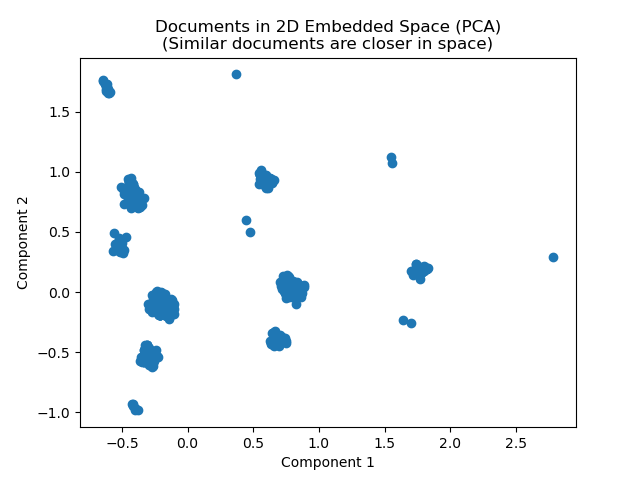

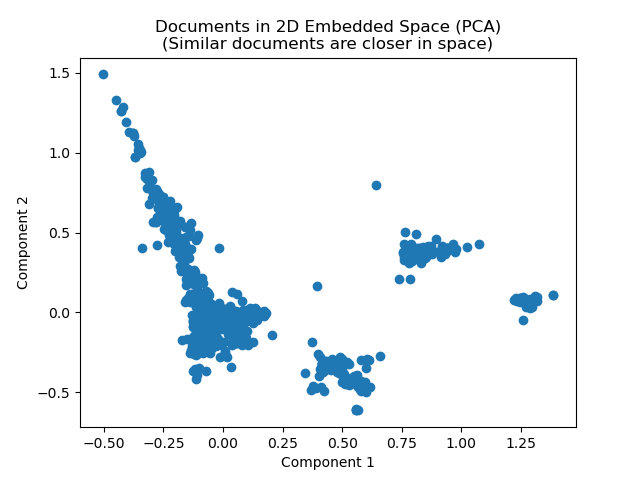

In [8]:
# Show documents in vector space, clusters indicate documents with similar terms
from sklearn.feature_extraction.text import CountVectorizer
from nlp import plot_document_matrix, preprocess_df
import pandas as pd

# Using BoW
bow = CountVectorizer()

# Plot documents in vector space before pre-processing
doc_term_matrix = bow.fit_transform(news_df["headline_text"])
plot_document_matrix(doc_term_matrix, n_samples=5000)

# Plot documents again after pre-processing
doc_term_matrix = bow.fit_transform(news_df["headline_text_preprocessed"])
plot_document_matrix(doc_term_matrix, n_samples=5000)

<a id="document-term"></a>
### Document-Term Matrix
A **document-term matrix** for a corpus of $m$ documents and vocabulary of size $n$, is a $m \times n$ matrix (left). each number in the matrix is the numeric representation for a term in a document. This is just a convenient way of representing a list of document vectors (right).
$$\text{document-term matrix} = \begin{Bmatrix} 
& w_1 & w_2 & \dots & w_n\\
D_1 & \dots & \dots & \dots & \dots \\
D_2 & \dots & \dots & \dots & \dots \\
D_3 & \dots & \dots & \dots & \dots \\
& & \vdots \\
D_m & \dots & \dots & \dots & \dots 
\end{Bmatrix}\ \  \equiv \ \ 
\begin{matrix}
D_1 = [\dots,\  \dots,\  \dots, \ \dots] \\
D_2 = [\dots,\  \dots,\  \dots, \ \dots] \\
D_3 = [\dots,\  \dots,\  \dots, \ \dots] \\
\vdots \\
D_m = [\dots,\  \dots,\  \dots, \ \dots] \\
\end{matrix}
$$

**NOTE**: Most of the times the resulting matrix will be *sparse* - this means most of the elements will be zero. Sparsity increase as vocabulary size increase as intuitively, if we have a lot of terms, most of our documents will only contain a small number of terms from the vocabulary. It's not likely in real life to have documents containing all or most of the terms in the vocabulary.

<a id="vectorisation-techniques"></a>
### Vectorisation Techniques

<a id="bow"></a>
#### Bag-of-Word (BoW)
The [Bag-of-Word model](https://en.wikipedia.org/wiki/Bag-of-words_model) represent each document as a list of frequency counts for each term in the vocabulary.

- Formally...
	- Given a vocabulary $V$ (with $|V|$ denoting the number of terms in $V$) with each term in it assigned a unique ID
	- a document $d_j$ is a vector of size $|V|$ that stores the number of times a term in $V$ occured in $d_j$

For example, consider the following corpus:

| Document | Text           |
| -------- | -------------- |
| D1       | dog bites man |
| D2       | man bites dog |
| D3       | dog bites meat and dog eats meat|

- $V = \set{\text{dog, bites, man, eats, meat, and}}$
	- each term is assigned an ID ranging from 1 to 6
- Then, D1 can be represented as a 6D vector where the $i$-th number represent how many times the $i$-th term in $V$ occured in D1:
$$\text{D1} = [1, 1, 1, 0, 0, 0]$$
- Applying this to all documents, we end up with the following document-term matrix:
$$
\begin{matrix}
V & =& \{\text{dog}, & \text{bites}, &  \text{man},& \text{eats}, & \text{meat}, &  \text{and}\} \\
\text{ID} & =& \{1,& 2,& 3,& 4,& 5,& 6\} \\
\\
D_1 & =& [1,& 1,& 1,& 0,& 0,&  0] \\
D_2 & =& [1,& 1,& 1,& 0,& 0,& 0] \\
D_3 & =& [2,& 1,& 0,& 1,& 1,& 1] \\
\end{matrix}
$$


In [9]:
# BoW in sklearn
# User guide:
#   https://scikit-learn.org/stable/modules/feature_extraction.html#the-bag-of-words-representation
# Documentation:
#   https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
doc_term_matrix = bow.fit_transform(example_corpus)

print(f'Corpus: {example_corpus}')
print(f'Vocabulary: {bow.get_feature_names_out()}')
print_matrix("Document-terms matrix (BoW):", doc_term_matrix)

Corpus: ['dog bites man', 'man bites dog', 'dog bites meat and dog eats meat']
Vocabulary: ['and' 'bites' 'dog' 'eats' 'man' 'meat']
Document-terms matrix (BoW):
Document 0:	[0.000,	1.000,	1.000,	0.000,	1.000,	0.000]
Document 1:	[0.000,	1.000,	1.000,	0.000,	1.000,	0.000]
Document 2:	[1.000,	1.000,	2.000,	1.000,	0.000,	2.000]


<a id="bog"></a>
#### Bag-of-$n$-Grams
The bag-of-$n$-grams model is the exact same as BoW, differing in only that each term in the vocabulary can consist of more than one word. These phrases consisting of $n$ words are called [$n$-grams](https://en.wikipedia.org/wiki/N-gram). For example, "dog", "cat", "chocolate" are 1-grams (AKA *unigrams*), "red dog", "black cat", "white chocolate" are 2-grams (AKA *bigrams*) and so forth. This captures word-order to some degree.

In [10]:
# Bag-of-n-grams in sklearn
from sklearn.feature_extraction.text import CountVectorizer

bog = CountVectorizer(ngram_range=(2, 2))
doc_term_matrix = bog.fit_transform(example_corpus)

print(f'Corpus: {example_corpus}')
print(f'Vocabulary: {bog.get_feature_names_out()}')
print_matrix("Document-terms matrix (BoG):", doc_term_matrix)

Corpus: ['dog bites man', 'man bites dog', 'dog bites meat and dog eats meat']
Vocabulary: ['and dog' 'bites dog' 'bites man' 'bites meat' 'dog bites' 'dog eats'
 'eats meat' 'man bites' 'meat and']
Document-terms matrix (BoG):
Document 0:	[0.000,	0.000,	1.000,	0.000,	1.000,	0.000,	0.000,	0.000,	0.000]
Document 1:	[0.000,	1.000,	0.000,	0.000,	0.000,	0.000,	0.000,	1.000,	0.000]
Document 2:	[1.000,	0.000,	0.000,	1.000,	1.000,	1.000,	1.000,	0.000,	1.000]


<a id="tfidf"></a>
#### TF-IDF
Stands for "*Term Frequency-Inverse-Document-Frequency*", [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) uses a weighting that reflects how important a term is to a document (as opposed to merely being a frequency count like in BoW). This TF-IDF weight value is high if a term only occurs in a small number of documents, with the idea that rarer terms like "scoliosis" are more likely to be meaningful as opposed to more commonly-used terms like "medical". 

For some term $t$ and some document $d$ in corpus $D$, the TF-IDF score is calculated as the product of TF and IDF:
$$\text{tf-idf}(t, d, D) = \text{tf}(t, d) \cdot \text{idf}(t, D)$$
$$\text{tf}(t, d) = \frac{\text{number of times }t \text{ occured in }d}{\text{total frequencies of terms in }d} = \frac{\text{count}(t, d)}{\sum\limits_{t' \in d} \text{count}(t', d)}$$
$$
\text{idf}(t, D) = \log \frac{\text{number of documents}}{\text{number of documents that } t \text{ occurs in}} =\log \frac{|D|}{|\set{d \in D: t \in d}|}
$$


In [11]:
# TF-IDF in sklearn
# User guide:
#   https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting
# Documentation
#   https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nlp import plot_document_matrix
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer()
doc_term_matrix = tfidf.fit_transform(example_corpus)

print(f'Corpus: {example_corpus}')
print(f'Vocabulary: {tfidf.get_feature_names_out()}')
print_matrix("Document-terms matrix (TF-IDF):", doc_term_matrix)

Corpus: ['dog bites man', 'man bites dog', 'dog bites meat and dog eats meat']
Vocabulary: ['and' 'bites' 'dog' 'eats' 'man' 'meat']
Document-terms matrix (TF-IDF):
Document 0:	[0.000,	0.523,	0.523,	0.000,	0.673,	0.000]
Document 1:	[0.000,	0.523,	0.523,	0.000,	0.673,	0.000]
Document 2:	[0.359,	0.212,	0.424,	0.359,	0.000,	0.719]


---

<a id="models"></a>
## 3. Topic Models
After vectorising the textual data, various models can then be applied on the resulting document-term matrix to possibly discover the topics in the corpus (often using unsupervised learning). Unfortunately the number of topics must be specified, and the hyperparameters of the model must be tuned experimentally to find interpretable topics from the data.

Due to time constraint, this notebook will only cover the most commonly used model - LDA.

<a id="lda"></a>
### Latent Dirichlet Allocation (LDA)
[LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is the most commonly used statistical model in topic modelling, where topics are described as *probability distribution* over the vocabulary (see ['What is a "Topic"?'](#topic)).

LDA discovers hidden variables ("*latent*") by "*allocating*" documents and topics to probability distributions ("*Dirichlet* distributions"). 

<a id='lda-overview'></a>
#### Blackbox Overview
Broadly speaking, with $k$ topics specified, LDA will decompose a document-term matrix $M$ into 2 submatrices:
- $M_1$ = *document-topic matrix*, dimension $(m, k)$ - show each document's topic mixture
- $M_2$ = *topic-terms matrix*, dimension $(k, n)$ - show word distribution for each topic

<a id="lda-doc-gen-eng"></a>
**Document Generation Process (plain-English)**

LDA accomplishes this decomposition by working on the assumption that documents can be generated by the following process. To generate a corpus of documents, we repeat this process for EACH document in the corpus:
1. Decide how many words the document should have
2. Choose the mixture of topic the document should have, e.g. 20% topic 1, 80% topic 2
3. For each topic, decide how frequently each word in vocabulary should appear (i.e. we decide the word distribution for each topic)
4. Then, to start writing, we generate each word by...
	1. first choose a topic from the mixture, e.g. we chose topic 1 with 20% chance
	2. Then, choose a word from that topic's word distribution, e.g. we chose some word from topic 1 with 82% chance and write that in

LDA then reverses this process by looking at the words in existing corpus to produce the two matrices.


<a id="lda-formalised-details"></a>
#### Formalised Details
This section can be quite math-heavy. I found that [this video](https://www.youtube.com/watch?v=T05t-SqKArY) has helped me quite a lot in understanding these concepts.

<a id="ida-formalised-variables"></a>
**Variable Names Definition**

| Variable | Definition                                                                                                                                                                                                                                                                                     |
| -------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| $M$      | Number of documents                                                                                                                                                                                                                                                                            |
| $N$      | Total number of words in corpus; $N_i$ = number of words in document $i$                                                                                                                                                                                                                       |
| $K$      | Number of topics                                                                                                                                                                                                                                                                               |
| $\alpha$ | Parameter of Dirichlet, used before the document-topic distribution ($\theta$)                                                                                                                                                                                                                 |
| $\beta$  | Parameter of Dirichlet, used before the topic-word distribution ($\phi$)                                                                                                                                                                                                                       |
| $\theta$ | Document-topic distribution, $\theta_i$ = topic distribution (mixture) for document $i$ <br>![](./attachments/2.png)<br><figcaption>RHS of image is the document-topic distribution, shows mixture of topic of each documents.</figcaption>                                                |
| $\phi$   | Topic-word distribution, $\phi_k$ = word distribution for topic $k$<br> ![](./attachments/3.png)<br> <figcaption>Bottom of image, shows how likely words are to occur for each topic. Intuitively "Referendum" should be more common than "Galaxy" in a political document.</figcaption> |
| $z_{ij}$ | Topic for the $j$-th word in document $i$<br>  ![](./attachments/4.png)<br><figcaption>Here we have collection of topics (for, say, 8-th document) for 9 words. z<sub>83</sub> = sports, z<sub>86</sub> = politics</figcaption>                                                                                                                                                                                                                                                    |
| $w_{ij}$ | Specific word being generated (for topic $z_{ij}$ in document $i$).<br> ![](./attachments/5.png)<br><figcaption>Say we have 3 topics with multinomial word distribution as these 3 boxes.</figcaption> <br>  ![](./attachments/6.png)<br> <figcaption>We randomly select some words. Assume this is the 8-th document. w<sub>81</sub> = planet, w<sub>82</sub> = galaxy, etc</figcaption>                                                                                                                                                                                                                         |

<a id="lda-doc-gen-formalised"></a>
**Formalised Document Generation Process**

The document generation process is visualised using [plate notation](https://en.wikipedia.org/wiki/Plate_notation) below. Think of the plates (rectangles) as for-loops. A number is labeled on the plate indicating how many iterations that section should repeat for.

![](./attachments/7.png)

- We have two [Dirichlet distributions](https://en.wikipedia.org/wiki/Dirichlet_distribution) $\text{Dir}(\alpha),\ \text{Dir}(\beta)$ where $\alpha$ and $\beta$ are the parameters (described further below)
- $\theta$ and $\phi$ denotes multinomial distributions generated from $\text{Dir}(\alpha),\ \text{Dir}(\beta)$ respectively. Think of them as two boxes of balls to pick from, and the balls represent topics or words respectively.
- $z$ is some topic we picked from $\theta$
- $w$ is the actual word for topic $z$ chosen from $\phi$

From the above diagram, document generation is then as such:
- To generate corpus of $D$ documents, with $K$ topics, where each $i$-th document have $N_i$ words:
1. For each $i$-th document (repeating $D$ times),
	- choose $\theta_i$ generated by $\text{Dir}(\alpha)$ (Dirichlet Distribution with param usually $\alpha < 1$)
2. For each $k$-th topic (repeating $K$ times),
	- choose $\phi_k$ generated by $\text{Dir}(\beta)$ (usually $\beta < 1$)
3. For each $j$-th word (repeat $N_i$ times) in each $i$-th document (repeat $D$ times)
	- choose topic $z_{ij}$ generated by $\text{Multinomial}(\theta_i)$
	- Then, choose word $w_{ij}$ generated by $\text{Multinomial}(\phi_{z_{ij}})$

<a id="dirichlet-dist"></a>
**Dirichlet Distribution**

[Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) is a continuous probability distribution over a list of unknown variables. In the case of LDA, two Dirichlet distributions $\theta$ and $\phi$ are used.

The distribution $\theta$ is the document-topic distribution. Say we have 3 topics (for convenience), these are our *unknown* variables. We can then visualise the Dirichlet distribution as a triangle, with the points inside it being the documents. Each document is a mixture of these 3 topics with their position on the triangle indicating that mixture. Below is an example image taken from the video mentioned above.

![](./attachments/2.png)

Similarly, $\phi$ is the topic-term distribution. The image below is again taken from the same video. Like defined in ['What is a "topic"?'](#topic), each topic is associated with a word distribution.

![](./attachments/3.png)

Notice how the two distributions $\theta$ and $\phi$ resembles the two submatrices $M_1$ and $M_2$ - the matrices are just another way of representing these distributions.

<a id="lda-topic-inference"></a>
**Topic Inference**

The goal of LDA is to learn the distribution $\theta$ and $\phi$. This is done by maximising the overall probability of the model.

$$
\large P(W, Z, \theta, \phi;\  \alpha, \beta)= 
\overbrace{\prod_{j=1}^M P(\underbrace{\theta_j}_{\text{topic dist}}; \alpha)\  \cdot \ 
\prod_{i = 1} ^K P(\underbrace{\phi_i}_{\text{word dist}}; \beta)} ^{\text{Dirichlet Distributions}} \  \cdot \
\overbrace{\prod ^N _{t = 1} P(\underbrace{z_{jt}}_{\text{topic}} | \theta_j)
\  \cdot\  P(\underbrace{w_{jt}}_{\text{word}} | \phi_{z_{jt}}) } ^{\text{Multinomial Distributions}}
$$

| Component                                  | Explanation                                                                                                            |
| ------------------------------------------ | ---------------------------------------------------------------------------------------------------------------------- |
| $P(W, Z, \theta, \phi;\ \alpha, \beta)$    | Overall probability of the model, this number is **very** low <ul><li>$W$ = vocabulary</li><li>$Z$ = list of all topics</li></ul>                                                                           |
| $\prod ^M_{j=1} P(\theta{j;\ \alpha})$     | Product of: probability of picking this topic mixture $\theta$ for each document ($M$ total documents), using param $\alpha$                |
| $\prod^K_{i=1}P(\phi_i;\ \beta)$           | Product of: probability of picking this word distribution $\phi$ for each topic ($K$ topics total), using param $\beta$                                        |
| $\prod^N_{t=1}P(z_{jt}\ \vert \ \theta_j)$ | Product of: given topic mixture $\theta$ for document $j$ was picked, probability of picking topic $z_j$ for each word ($N$ words total) |
| $P(w_{jt}\ \vert \ \phi_{z_{jt}})$         | Given that word distribution $\phi$ for topic $z$ in document $j$ (for the $t$-th word) is picked, probability of choosing $t$-th word $w$ in document $j$                        |

*Note that the 4 components are the same 4 components in the document generation section.*

Since $w_{jt}$ (the words in the documents) is the only thing LDA can see, it's difficult to maximise the above equation. Hence, [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) is often used to accomplish this task (I won't go into it here because I don't understand it that well myself). LDA essentially repeatedly generate new documents and compare it with the original documents, and the $\theta, \phi$ distributions that give the most similar documents to the original is chosen and used in the next iteration.


In [12]:
# LDA in sklearn, using BoW document-term matrix
# User guide:
#   https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn-decomposition-latentdirichletallocation
# Documentation:
#   https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 6    # Play around with this value to see different results!

vectoriser = CountVectorizer()
doc_term_matrix = vectoriser.fit_transform(news_corpus)

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10)
doc_topic_matrix = lda.fit_transform(doc_term_matrix)
topic_term_matrix = lda.components_

/home/tin/mambaforge/envs/gcrl2000/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.090566 -0.172006       1        1  19.428002
3     -0.055758  0.006765       2        1  18.708969
4     -0.128888  0.103039       3        1  16.620662
5      0.148182 -0.014739       4        1  16.231813
0      0.094790 -0.035443       5        1  16.026536
2      0.032241  0.112385       6        1  12.984017, topic_info=           Term        Freq       Total Category  logprob  loglift
7747        war  350.000000  350.000000  Default  30.0000  30.0000
7402      troop  105.000000  105.000000  Default  29.0000  29.0000
480        anti  109.000000  109.000000  Default  28.0000  28.0000
734     baghdad  122.000000  122.000000  Default  27.0000  27.0000
7488         un   91.000000   91.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
4522  melbourne   16.839906   42.534513   Topic6  -5.9962   1.1149
5841     record   17.387483   55.503643   Topic6  -5.9642   0.8808
6287        say   20.519256  208.711999   Topic6  -5.7986  -0.2781
4939        nsw   17.894212  123.985270   Topic6  -5.9355   0.1058
7885        win   17.503121  170.983335   Topic6  -5.9576  -0.2377

[420 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
42        2  0.869203        17
107       1  0.897619        30
230       5  0.922816      accc
235       2  0.210586  accident
235       3  0.710729  accident
...     ...       ...       ...
7954      4  0.386205     world
7954      5  0.025187     world
7954      6  0.327435     world
7959      5  0.943736     worry
8020      2  0.948391   zealand

[778 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 6, 1, 3])

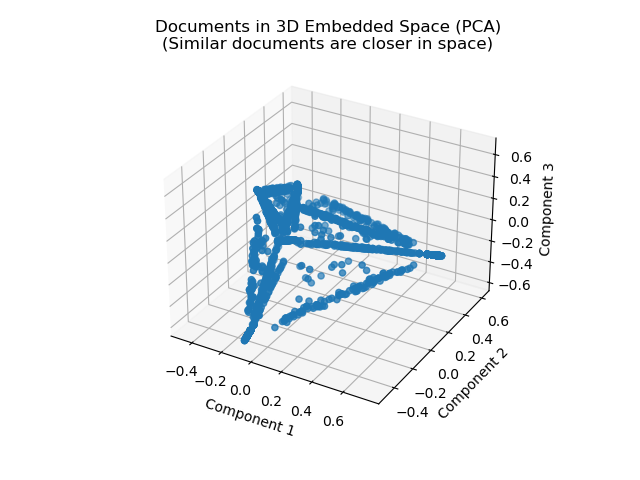

In [13]:
# Visualise each document with regards to their topic mixture
plot_document_matrix(doc_topic_matrix, dimension=3)

import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

# pyLDAvis calls get_feature_names() instead of get_feature_names_out()
vectoriser.get_feature_names = vectoriser.get_feature_names_out
pyLDAvis.sklearn.prepare(lda, doc_term_matrix, vectoriser)